In [ ]:
'''


'''

# Import

In [4]:
%matplotlib notebook
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np, sympy as sy, visa
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys, imp, pandas as pd
from tqdm import tqdm_notebook as tqdm
# from easydl import clear_output
from sklearn.cluster import KMeans
from qulab.math.qst import transformList, acquireVFromData, vToRho
from qulab.math import opt
from qulab import ezQ_inst, measure_1027
from qulab import computewave_1027, waveform, optimize
from qulab import simpletes
sim = imp.reload(simpletes)
op = imp.reload(optimize)
cww = imp.reload(computewave_1027)
ezQ_inst = imp.reload(ezQ_inst)
wn = imp.reload(waveform)
mrw = imp.reload(measure_1027)

# 指定仪器

In [2]:
psg_lo = await connect('PSG27')
psg_ex = await connect('PSG28')
psg_pump = await connect('PSG25')

att6 = await connect('Att6')
 
dcch1 = ezQ_inst.DC('DC1','10.0.200.72',5000,1)
dcch2 = ezQ_inst.DC('DC1','10.0.200.72',5000,2)
dcch3 = ezQ_inst.DC('DC1','10.0.200.72',5000,3)
dcch4 = ezQ_inst.DC('DC1','10.0.200.72',5000,4)

awg_read = ezQ_inst.DA('QF10K4N0050', '10.0.200.68')#读出
awg_exAB = ezQ_inst.DA('QF10K4N0075', '10.0.200.70')#XYA,XYB
awg_exCD  = ezQ_inst.DA('QF10K4N0064', '10.0.200.69')#XYC,XYD
awg_Z = ezQ_inst.DA('QF10K4N0034', '10.0.200.71')#Z_pulse

ad = ezQ_inst.AD('QE10K4N0016', '00-00-00-00-00-60', "B4-96-91-78-AB-0E")

att = {
    'att1':att6,
    'att2':att6,
    'att3':att6,
    'att4':att6,
    'jpa':att6,
}

dc = {
    'dcch1':dcch1,
    'dcch2':dcch2,
    'dcch3':dcch3,
    'dcch4':dcch4,
    'jpa':dcch4,
}

psg = {
    'psg_lo':psg_lo,
    'psg_ex':psg_ex,
    'psg_trans':psg_lo,
    'psg_pump':psg_pump
}

awg = {'awg1':awg_read,
       'awg2':awg_exAB, 
       'awg3':awg_exCD,
       'awg4':awg_Z,
      }

''' 
一个Z地址有四个通道，序号从1到4
'''
z_ch1 = 1
z_ch2 = 2
z_ch3 = 3
z_ch4 = 4


''' 
ex激励IQ通道,A\C通道的IQ编号[1,2],B\D通道的IQ编号[3,4],
'''
e_ch1 = [1,2]
e_ch2 = [3,4]
e_ch3 = [1,2]
e_ch4 = [3,4]

'''
读出通道IQ,编号[1,2]
'''
l_ch1 = [1,2]
l_ch2 = [1,2]
l_ch3 = [1,2]
l_ch4 = [1,2]


# 比特参数

In [5]:
Nb_cavity = np.array([6.661,6.681,6.694,6.710,6.725,6.741,6.756,6.767,6.781,6.792])*1e9
jpa = mrw.qubit(q_name='jpa',inst={'dc':'jpa','pump':'psg_pump'},bias=-4.167,f_ex=2*6.75e9+2e6,power_ex=5.81) #power=-2.1
f_cavity = np.array([6.505,6.518,6.53,6.542,6.557,6.568,6.587,6.601,6.6045,6.628])*1e9
f_ca = np.array([6.505,6.518,6.53,6.542,6.557,6.568,6.601,6.6045])*1e9
# freqall = {f'q{i+1}':j for i,j in enumerate(f_cavity)} ####q1--q10
freqall = {f'q{i+1}':j for i,j in enumerate(f_ca)}  ####q1--q8
califreqall = {f'q{i+1}':j for i,j in enumerate(f_cavity[0:4])}  ####q1--q4

q1 = mrw.qubit(
    q_name='q1',
    inst={'dc':'dcch1',
          'z_awg':'awg4', 
          'z_ch':z_ch1,
          'lo_awg':'awg1',
          'lo_ch':l_ch1,
          'ex_awg':'awg2',
          'ex_ch':e_ch1,
          'psg_lo':'psg_lo',
          'att':'att1'
         },
    f_lo=np.array([6.505e9]), 
    delta=np.array([50e6]), 
    bias=1.3, 
    zpulse=None,
    f_ex=np.array([3.652e9]), 
    delta_ex=np.array([200e6]),
    pi_len=24,
    power_ex = 29000)
q2 = mrw.qubit(
    q_name='q2',
    inst={'dc':'dcch2',
          'z_awg':'awg4', 
          'z_ch':z_ch2,
          'lo_awg':'awg1',
          'lo_ch':l_ch2,
          'ex_awg':'awg2',
          'ex_ch':e_ch2,
          'psg_lo':'psg_lo',
          'att':'att2'
         },
    f_lo=np.array([6.518e9]), 
    delta=np.array([50e6]), 
    bias=1.3, 
    zpulse=None,
    f_ex=np.array([3.652e9]), 
    delta_ex=np.array([200e6]),
    pi_len=24,
    power_ex = 29000)
q3 = mrw.qubit(
    q_name='q3',
    inst={'dc':'dcch3',
          'z_awg':'awg4', 
          'z_ch':z_ch3,
          'lo_awg':'awg1',
          'lo_ch':l_ch3,
          'ex_awg':'awg3',
          'ex_ch':e_ch3,
          'psg_lo':'psg_lo',
          'att':'att3'
         },
    f_lo=np.array([6.52988e9]), 
    delta=np.array([50e6]), 
    bias=3, 
    zpulse=None,
    f_ex=np.array([3.652e9]), 
    delta_ex=np.array([200e6]),
    pi_len=24,
    power_ex = 29000)
q4 = mrw.qubit(
    q_name='q4',
    inst={'dc':'dcch4',
          'z_awg':'awg4', 
          'z_ch':z_ch4,
          'lo_awg':'awg1',
          'lo_ch':l_ch4,
          'ex_awg':'awg3',
          'ex_ch':e_ch4,
          'psg_lo':'psg_lo',
          'att':'att4'
         },
    f_lo=np.array([6.54137e9]), 
    delta=np.array([50e6]), 
    bias=2.8, 
    zpulse=None,
    f_ex=np.array([3.62e9]), 
    delta_ex=np.array([200e6]),
    pi_len=100,
    power_ex = 32000)

###测量类  def __init__(self,freqall,ad,dc,psg,awg,att,jpa,qubits):

qubits=[q1,q2,q3,q4]
caliqubits = [q1,q2,q3,q4]
measure = mrw.common(f_cavity,ad,dc,psg,awg,att,jpa,qubits)
depth = 2000
trig_count = 300
trig_interval = 260e-6
mode = 1
amp = 32767.5  # 避免越界，比32768略小
ad_trig_delay = 90354e-9 #s 王子婷设的
# ad_trig_delay = 106354e-9#s

flo = []
for k,q in enumerate(qubits):
    flo.append(q.f_lo[0])
f_lo, delta, n = mrw.resn(np.array(flo))

f_lo, delta, n = mrw.resn(np.array([6.505e9]*8))
freqall = {f'q{i+1}':j for i,j in enumerate(np.array([6.505e9]*8))}

# f_lo, delta, n = mrw.resn(np.array([6.505e9,6.518e9]*4))
# freqall = {f'q{i+1}':j for i,j in enumerate(np.array([6.505e9,6.518e9]*4))}

measure.caliqubits = caliqubits
measure.qubits = qubits
measure.delta = delta 
measure.n = n 
measure.f_lo = f_lo 
measure.readlen = depth
measure.mode = mode
measure.trig_count = trig_count
measure.trig_interval = trig_interval

measure.freqall = freqall
measure.califreqall = califreqall
measure.ad = ad
measure.awg = awg
measure.psg = psg
measure.att = att
measure.dc = dc

In [7]:
measure.califreqall

{'q1': 6505000000.0,
 'q2': 6518000000.0,
 'q3': 6530000000.0,
 'q4': 6542000000.0}

In [6]:
measure.caliqubits

In [22]:
f_lo, delta, n

(6425000000.0,
 array([80000000., 80000000., 80000000., 80000000., 80000000., 80000000.,
        80000000., 80000000.]),
 8)

#  crosstalk 矩阵

In [5]:
Q6 = [-2.83231315e-02,  - 1.88411060e-02,  -2.56171059e-02,1 ]
Q3 = [1, -1.08536585e-02, -6.30313591e-03, -1.47421603e-02]
Q4 = [4.15911354e-02, 1, -2.12507013e-02, -2.14484257e-02]
Q5 = [2.56192648e-02, 1.85674370e-02, 1, -2.31954667e-02 ]


calimatrix=np.array([Q3,Q4,Q5,Q6])
calimatrix = np.eye(4)          ####测量crosstalk 矩阵时，选此项
calimatrix = np.mat(calimatrix)

# 链接仪器

In [10]:
for i in measure.awg:
    measure.awg[i].da_connect_device()
measure.ad.ad_connect_device()

da board:[QF10K4N0050] connect success .
da board:[QF10K4N0075] connect success .
da board:[QF10K4N0064] connect success .
da board:[QF10K4N0034] connect success .
0000


['频率(MHz)：79.99998331069946', '频率(MHz)：79.99998331069946', '频率(MHz)：79.99998331069946', '频率(MHz)：79.99998331069946', '频率(MHz)：79.99998331069946', '频率(MHz)：79.99998331069946', '频率(MHz)：79.99998331069946', '频率(MHz)：79.99998331069946']
['解模长度：2000', '解模长度：2000', '解模长度：2000', '解模长度：2000', '解模长度：2000', '解模长度：2000', '解模长度：2000', '解模长度：2000']
['解模窗口：2000', '解模窗口：2000', '解模窗口：2000', '解模窗口：2000', '解模窗口：2000', '解模窗口：2000', '解模窗口：2000', '解模窗口：2000']
['解模起始：0', '解模起始：0', '解模起始：0', '解模起始：0', '解模起始：0', '解模起始：0', '解模起始：0', '解模起始：0']
['态判断参数A：0', '态判断参数A：0', '态判断参数A：0', '态判断参数A：0', '态判断参数A：0', '态判断参数A：0', '态判断参数A：0', '态判断参数A：0']
['态判断参数B：0', '态判断参数B：0', '态判断参数B：0', '态判断参数B：0', '态判断参数B：0', '态判断参数B：0', '态判断参数B：0', '态判断参数B：0']
['态判断参数C1：0', '态判断参数C1：0', '态判断参数C1：0', '态判断参数C1：0', '态判断参数C1：0', '态判断参数C1：0', '态判断参数C1：0', '态判断参数C1：0']
['态判断参数C2：0', '态判断参数C2：0', '态判断参数C2：0', '态判断参数C2：0', '态判断参数C2：0', '态判断参数C2：0', '态判断参数C2：0', '态判断参数C2：0']
已收到的触发个数：300
已完成触发解模个数：300
上位机读分段长度：80
AD 触发自适应状态：未完成xxx
SRAM校准状态：AD SRA

0

# 初始化仪器

In [9]:
#初始化
for i in measure.awg:
    measure.awg[i].da_init_device(trig_interval)
    measure.awg[i].da_trigg(trig_count)
measure.ad.ad_init_device()
#采集数据出发时间延迟
awg_read.da_set_trig_delay(ad_trig_delay)#AWG主板
measure.ad.set_ad(depth, trig_count, mode=1)## 1,做傅里叶变换，频域信号；0，不做傅里叶变换，时域信号
measure.ad.ad_data_clear()
measure.ad.set_ad_freq(delta, depth, window_start=8)

Trig_delay should be a multiple of 4ns,otherwise we'll round it up.In this case,the real value of trig_delay is 90356ns
Width+trig_delay should be a multiple of 4ns,otherwise we'll round it up.In this case,the real value of width+trig_delay is 90392ns


300
da board:[QE10K4N0016] set param success .


0

# 时域信号

In [11]:
cww.modulation_read(measure, measure.delta, readlen=measure.readlen)

(array([30000.        , 29057.49483386, 26289.20040132, ...,
            0.        ,     0.        ,     0.        ]),
 array([    0.        ,  7460.69661495, 14452.61022305, ...,
            0.        ,     0.        ,     0.        ]))

In [10]:
await psg['psg_lo'].setValue('Power',24)
await att6.set_att(0)

<IPython.core.display.Javascript object>


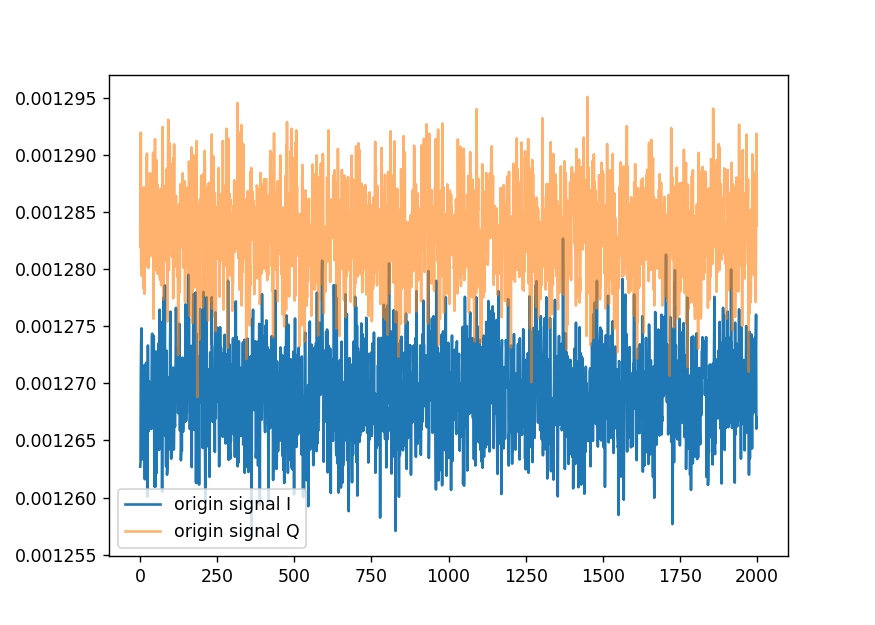

In [12]:
%matplotlib notebook
I, Q = 0, 0
await psg['psg_lo'].setValue('Output','ON')
await psg['psg_lo'].setValue('Frequency',6e9)
# await psg['psg_ex'].setValue('Output','OFF')
for i in range(1):
    chA, chB = measure.ad.getTraces()
    I += chA
    Q += chB
plt.figure(figsize=(7,5))
plt.plot(np.arange(len(I)), I,label='origin signal I')
plt.plot(np.arange(len(Q)), Q,label='origin signal Q',alpha=0.6)
#plt.plot(np.arange(len(Q)), np.sqrt(I**2+Q**2),'.',label='envelop')
plt.legend(loc="lower left")
plt.show()

# 频域信号

[80000000. 80000000. 80000000. 80000000. 80000000. 80000000. 80000000.
 80000000.]


<IPython.core.display.Javascript object>


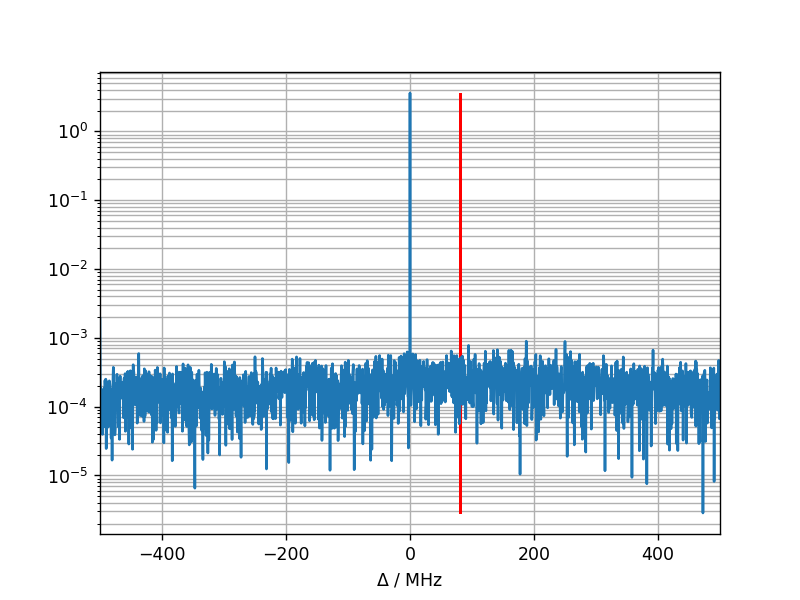

In [13]:
x = np.fft.fftshift(np.fft.fftfreq(len(I)))*1e9
y = np.fft.fftshift(np.fft.fft(I + 1j*Q))
Delta_list = measure.delta
print(Delta_list)
plt.figure()

plt.vlines(Delta_list/1e6, np.min(np.abs(y)), np.max(np.abs(y)), 'r')

plt.semilogy(x/1e6, np.abs(y))

plt.grid(which='both')
plt.xlabel(r'$\Delta$ / MHz')
plt.xlim(-500,500)
plt.show()

# S21

In [23]:
q_target = q1
freq = np.linspace(6.676,6.686,4001)*1e9 -80e6
await att6.set_att(0)
job = Job(mrw.S21, (q_target,measure,False,f_lo,freq),auto_save=True,max=len(freq),tags=[q_target.q_name])
f_s21, s_s21 = await job.done()

fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21[:,0],20*np.log10(np.abs(s_s21[:,0])))
# axes[0].vlines(f_lo+delta,np.max(20*np.log10(np.abs(s_s21))),np.min(20*np.log10(np.abs(s_s21))),'r')
# axes[1].vlines(f_lo+delta,np.max(np.angle(s_s21)),np.min(np.angle(s_s21)),'r')
# axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

Output()

TypeError: cannot unpack non-iterable NoneType object

In [19]:
q_target = q1
freq = np.linspace(6.5,6.63,1201)*1e9 
tag = q_target.q_name
# await mrw.dcManage(measure,'DC',dcstate={'q1':1.2, 'q2':0.7, 'q3':3, 'q4':-4.167},readstate=None,calimatrix=None)
# measure.dc[q_target.q_name].dc(flux)
await att6.set_att(22)
# await measure.attinst['com8'].set_att(38)
# await mr.jpa_switch(measure,state='ON')
f_lo, delta, n, f_res,base,f_s21, s_s21 = await mrw.again(q_target,measure,True,measure.f_lo)
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(9,4))
axes[0].plot(f_s21,20*np.log10(np.abs(s_s21)))
axes[0].vlines(f_lo+delta,np.max(20*np.log10(np.abs(s_s21))),np.min(20*np.log10(np.abs(s_s21))),'r')
axes[1].vlines(f_lo+delta,np.max(np.angle(s_s21)),np.min(np.angle(s_s21)),'r')
axes[1].plot(f_s21,np.angle(s_s21))
plt.show()

AttributeError: module 'qulab.measure_1027' has no attribute 'again'

In [24]:
q1.f_ex

array([3.652e+09])

# S21vsflux

# S21vsPower

# singlespec

# Rabi

# T1

# Ramsey

# Spinecho